In [1]:
# !pip install torch torchvision matplotlib scikit-image --quiet
!pip install lpips --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 4.9 MB/s eta 0:00:00


In [ ]:
import sys
import os
import math
import random
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, Subset

import torchvision
from torchvision import transforms

import matplotlib.pyplot as plt

from skimage.metrics import structural_similarity as ssim_metric
import lpips

# from google.colab import drive
# drive.mount('/content/drive')


# sys.path.append('/content/drive/My Drive/2025 Fall/ECE253/FFDNet-main/')
# path="/content/drive/My Drive/2025 Fall/ECE253/FFDNet-main/"
# os.chdir(path)
# os.listdir(path)

Mounted at /content/drive


['data_stl10',
 'DIV2K_train_HR',
 'ffdnet_stl10_official_style.pth',
 'real_noisy_eval',
 'data_div2k',
 'FFDNet_trained.pth',
 'FFDNet_new.ipynb',
 'FFDNet_baseline_stl10.pth',
 'FFDNet_sidd.ipynb',
 'FFDNet.ipynb',
 'FFDNet_DIV2K_split80_20.ipynb']

In [3]:
# Minimal replacement for `models.basicblock` as B

class PixelUnShuffle(nn.Module):
    """Inverse of PixelShuffle. Downscale by factor r, increase channels by r^2."""
    def __init__(self, upscale_factor):
        super().__init__()
        self.r = upscale_factor

    def forward(self, x):
        # x: (N, C, H, W)
        r = self.r
        N, C, H, W = x.size()
        assert H % r == 0 and W % r == 0, "H and W must be divisible by r"
        x = x.view(N, C, H // r, r, W // r, r)
        x = x.permute(0, 1, 3, 5, 2, 4).contiguous()  # (N, C, r, r, H//r, W//r)
        x = x.view(N, C * r * r, H // r, W // r)
        return x


def conv(in_nc, out_nc, mode='C', bias=True):
    """
    Build a small conv block according to mode string, e.g.:
    'C'  : Conv
    'CR' : Conv + ReLU
    'CBR': Conv + BN + ReLU
    'CBL': Conv + BN + LeakyReLU
    """
    layers = []
    # Conv
    layers.append(nn.Conv2d(in_nc, out_nc, kernel_size=3, stride=1, padding=1, bias=bias))
    # Parse rest
    if 'B' in mode:
        layers.append(nn.BatchNorm2d(out_nc))
    if 'R' in mode:
        layers.append(nn.ReLU(inplace=True))
    if 'L' in mode:
        layers.append(nn.LeakyReLU(0.1, inplace=True))
    return nn.Sequential(*layers)


def sequential(*args):
    """
    Flatten nested nn.Sequential / modules into a single nn.Sequential.
    """
    modules = []
    for module in args:
        if isinstance(module, nn.Sequential):
            for submodule in module.children():
                modules.append(submodule)
        elif isinstance(module, nn.Module):
            modules.append(module)
        elif isinstance(module, (list, tuple)):
            for sub in module:
                if isinstance(sub, nn.Sequential):
                    for submodule in sub.children():
                        modules.append(submodule)
                else:
                    modules.append(sub)
        else:
            raise TypeError(f"Unsupported type in sequential: {type(module)}")
    return nn.Sequential(*modules)


# mimic module namespace
class B:
    PixelUnShuffle = PixelUnShuffle
    conv = staticmethod(conv)
    sequential = staticmethod(sequential)


In [4]:
# FFDNet implementation using our inline B

class FFDNet(nn.Module):
    def __init__(self, in_nc=1, out_nc=1, nc=64, nb=15, act_mode='R'):
        """
        in_nc: channel number of input
        out_nc: channel number of output
        nc: channel number of feature maps
        nb: total number of conv layers
        act_mode: e.g. 'R', 'BR', 'BL', etc.
        """
        super(FFDNet, self).__init__()
        assert 'R' in act_mode or 'L' in act_mode, 'Examples: R, L, BR, BL, IR, IL'
        bias = True
        sf = 2  # scale factor for pixel unshuffle/shuffle

        self.m_down = B.PixelUnShuffle(upscale_factor=sf)

        # head: input is downsampled image (in_nc*sf^2) + 1 noise channel
        m_head = B.conv(in_nc * sf * sf + 1, nc, mode='C' + act_mode[-1], bias=bias)

        # body: nb-2 conv blocks
        m_body = [B.conv(nc, nc, mode='C' + act_mode, bias=bias) for _ in range(nb - 2)]

        # tail: back to out_nc * sf^2 (noise in downsampled space)
        m_tail = B.conv(nc, out_nc * sf * sf, mode='C', bias=bias)

        self.model = B.sequential(m_head, *m_body, m_tail)
        self.m_up = nn.PixelShuffle(upscale_factor=sf)

    def forward(self, x, sigma):
        """
        x:     (N, in_nc, H, W)   in [0,1]
        sigma: (N, 1, 1, 1)      scalar noise level per image (in [0,1])
        """
        h, w = x.size()[-2:]
        # pad so H,W are even
        paddingBottom = int(np.ceil(h / 2) * 2 - h)
        paddingRight  = int(np.ceil(w / 2) * 2 - w)
        x = torch.nn.ReplicationPad2d((0, paddingRight, 0, paddingBottom))(x)

        # downsample to subimages
        x = self.m_down(x)  # (N, in_nc*4, H/2, W/2)

        # noise map expanded to spatial dims
        m = sigma.repeat(1, 1, x.size(-2), x.size(-1))  # (N,1,H/2,W/2)
        x = torch.cat((x, m), dim=1)  # concat along channels

        x = self.model(x)
        x = self.m_up(x)  # upsample back to original resolution

        # remove padding
        x = x[..., :h, :w]
        return x


In [5]:
from torchvision import transforms
import torchvision

class STL10DenoiseFFDNet(Dataset):
    """
    STL10-based denoising dataset for FFDNet.
    Returns:
        noisy:  (3,H,W)  in [0,1]
        clean:  (3,H,W)  in [0,1]
        sigma:  (1,1,1)  scalar noise level in [0,1]
    """
    def __init__(self, root, split='train',
                 sigma_range=(0.0, 50.0/255.0),
                 download=True):
        super().__init__()

        self.dataset = torchvision.datasets.STL10(
            root=root,
            split=split,            # 'train' or 'test'
            download=download,
            transform=transforms.ToTensor()  # (3,96,96) in [0,1]
        )
        self.sigma_range = sigma_range

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        clean, _ = self.dataset[idx]   # (3,96,96)

        # choose sigma
        if self.sigma_range[0] == self.sigma_range[1]:
            sigma = self.sigma_range[0]
        else:
            sigma = random.uniform(*self.sigma_range)

        sigma_tensor = torch.tensor([[[sigma]]], dtype=clean.dtype)  # (1,1,1)

        # add AWGN
        noise = torch.randn_like(clean) * sigma
        noisy = (clean + noise).clamp(0.0, 1.0)

        return noisy, clean, sigma_tensor


In [ ]:
data_root = "./Datasets/data_stl10"

# Train: random sigma in [0, 50/255]
train_dataset_full = STL10DenoiseFFDNet(
    root=data_root,
    split='train',
    sigma_range=(0.0, 50.0/255.0),
    download=True
)

# Test: fixed sigma = 25/255
sigma_test = 25.0 / 255.0
test_dataset_full = STL10DenoiseFFDNet(
    root=data_root,
    split='test',
    sigma_range=(sigma_test, sigma_test),
    download=True
)

print("Full STL10 train size:", len(train_dataset_full))  # 5000
print("Full STL10 test size:", len(test_dataset_full))    # 8000

# Use subsets for speed
max_train_samples = 5000   # you can reduce (e.g., 2000) to go faster
max_test_samples  = 2000

train_indices = torch.randperm(len(train_dataset_full))[:max_train_samples]
test_indices  = torch.randperm(len(test_dataset_full))[:max_test_samples]

train_dataset = Subset(train_dataset_full, train_indices)
test_dataset  = Subset(test_dataset_full, test_indices)

print("Subset train size:", len(train_dataset))
print("Subset test size:", len(test_dataset))


Full STL10 train size: 5000
Full STL10 test size: 8000
Subset train size: 5000
Subset test size: 2000


In [ ]:
# import os
# model_path = "/content/drive/My Drive/2025 Fall/ECE253/FFDNet-main/FFDNet_trained.pth"
model_path = "./FFDNet_trained.pth"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

use_pin_memory = (device.type == "cuda")

train_loader = DataLoader(
    train_dataset,
    batch_size=32,
    shuffle=True,
    num_workers=0,
    pin_memory=use_pin_memory
)

test_loader = DataLoader(
    test_dataset,
    batch_size=32,
    shuffle=False,
    num_workers=0,
    pin_memory=use_pin_memory
)

# --------------------------
# Create model
# --------------------------
# FFDNet for RGB
model = FFDNet(in_nc=3, out_nc=3, nc=64, nb=15, act_mode='R').to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

# ------------------------------------
# LPIPS MODEL INITIALIZATION (REQUIRED)
# ------------------------------------
import lpips
lpips_fn = lpips.LPIPS(net='alex').to(device)
lpips_fn.eval()

print("Number of parameters:", sum(p.numel() for p in model.parameters()))

# --------------------------
# Load pretrained weights if file exists
# --------------------------
if os.path.exists(model_path):
    print(f"→ Found pretrained model at {model_path}, loading...")
    state = torch.load(model_path, map_location=device)
    model.load_state_dict(state)
    print("→ Pretrained weights loaded successfully!")
else:
    print("→ No pretrained model found. Training from scratch.")

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

print("Number of parameters:", sum(p.numel() for p in model.parameters()))


Using device: cuda
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /usr/local/lib/python3.12/dist-packages/lpips/weights/v0.1/alex.pth
Number of parameters: 494540
→ No pretrained model found. Training from scratch.
Number of parameters: 494540


In [9]:
def batch_psnr(pred, target):
    """
    pred, target: (B,C,H,W) in [0,1]
    returns mean PSNR over batch (float)
    """
    mse = F.mse_loss(pred, target, reduction='none')
    mse = mse.view(mse.size(0), -1).mean(dim=1)  # per-sample MSE
    psnr = 10 * torch.log10(1.0 / (mse + 1e-10))
    return psnr.mean().item()


def batch_ssim(pred, target):
    """
    pred, target: (B,C,H,W) in [0,1]
    returns mean SSIM over batch (float)
    """
    pred_np = pred.detach().cpu().numpy()
    target_np = target.detach().cpu().numpy()
    B, C, H, W = pred_np.shape
    vals = []
    for b in range(B):
        x = np.transpose(pred_np[b], (1, 2, 0))   # (H,W,C)
        y = np.transpose(target_np[b], (1, 2, 0)) # (H,W,C)
        # compatibility with different skimage versions
        try:
            s = ssim_metric(y, x, channel_axis=-1, data_range=1.0)
        except TypeError:
            s = ssim_metric(y, x, multichannel=True, data_range=1.0)
        vals.append(s)
    return float(np.mean(vals))


def batch_lpips(pred, target):
    """
    pred, target: (B,C,H,W) in [0,1]
    returns mean LPIPS over batch (float, lower is better)
    """
    # LPIPS expects tensors in [-1, 1]
    x = pred * 2.0 - 1.0
    y = target * 2.0 - 1.0
    with torch.no_grad():
        d = lpips_fn(x, y)  # (B,1) or (B,1,1,1)
    return d.mean().item()


num_epochs = 20  # or whatever you want

for epoch in range(num_epochs):
    # --------------------------
    # TRAINING LOOP
    # --------------------------
    model.train()
    running_loss = 0.0

    for noisy, clean, sigma in train_loader:
        noisy = noisy.to(device)
        clean = clean.to(device)
        sigma = sigma.to(device)

        optimizer.zero_grad()
        output = model(noisy, sigma).clamp(0.0, 1.0)
        loss = criterion(output, clean)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # compute mean loss for this epoch
    epoch_loss = running_loss / len(train_loader)

    # --------------------------
    # VALIDATION STEP (1 batch)
    # --------------------------
    model.eval()
    with torch.no_grad():
        noisy_val, clean_val, sigma_val = next(iter(test_loader))

        noisy_val = noisy_val.to(device)
        clean_val = clean_val.to(device)
        sigma_val = sigma_val.to(device)

        denoised_val = model(noisy_val, sigma_val).clamp(0.0, 1.0)

        psnr_val = batch_psnr(denoised_val, clean_val)
        ssim_val = batch_ssim(denoised_val, clean_val)
        lpips_val = batch_lpips(denoised_val, clean_val)

    # --------------------------
    # SAVE MODEL CHECKPOINT
    # --------------------------
    torch.save(model.state_dict(), model_path)
    print(f"Model saved to {model_path}")

    print(
        f"Epoch [{epoch+1}/{num_epochs}]  "
        f"Train Loss: {epoch_loss:.6f}  "
        f"Val PSNR: {psnr_val:.2f} dB  "
        f"Val SSIM: {ssim_val:.4f}  "
        f"Val LPIPS: {lpips_val:.4f}"
    )

# final save (optional – same path)
torch.save(model.state_dict(), model_path)
print(f"Final model saved to {model_path}")

Model saved to /content/drive/My Drive/2025 Fall/ECE253/FFDNet-main/FFDNet_trained.pth
Epoch [1/20]  Train Loss: 0.035683  Val PSNR: 20.03 dB  Val SSIM: 0.6047  Val LPIPS: 0.5984
Model saved to /content/drive/My Drive/2025 Fall/ECE253/FFDNet-main/FFDNet_trained.pth
Epoch [2/20]  Train Loss: 0.010765  Val PSNR: 20.02 dB  Val SSIM: 0.5830  Val LPIPS: 0.5580
Model saved to /content/drive/My Drive/2025 Fall/ECE253/FFDNet-main/FFDNet_trained.pth
Epoch [3/20]  Train Loss: 0.009722  Val PSNR: 21.99 dB  Val SSIM: 0.7183  Val LPIPS: 0.4551
Model saved to /content/drive/My Drive/2025 Fall/ECE253/FFDNet-main/FFDNet_trained.pth
Epoch [4/20]  Train Loss: 0.008421  Val PSNR: 20.91 dB  Val SSIM: 0.6860  Val LPIPS: 0.4352
Model saved to /content/drive/My Drive/2025 Fall/ECE253/FFDNet-main/FFDNet_trained.pth
Epoch [5/20]  Train Loss: 0.006317  Val PSNR: 23.67 dB  Val SSIM: 0.7454  Val LPIPS: 0.3403
Model saved to /content/drive/My Drive/2025 Fall/ECE253/FFDNet-main/FFDNet_trained.pth
Epoch [6/20]  Trai

In [10]:
model.eval()
test_psnr_total = 0.0
num_batches = 0

with torch.no_grad():
    for noisy, clean, sigma in test_loader:
        noisy = noisy.to(device)
        clean = clean.to(device)
        sigma = sigma.to(device)

        denoised = model(noisy, sigma).clamp(0.0, 1.0)
        psnr_batch = batch_psnr(denoised, clean)
        test_psnr_total += psnr_batch
        num_batches += 1

avg_test_psnr = test_psnr_total / num_batches
print(f"Average PSNR on STL10 test set (σ={sigma_test*255:.1f}): {avg_test_psnr:.2f} dB")


Average PSNR on STL10 test set (σ=25.0): 26.13 dB


In [11]:
model.eval()
test_psnr_total = 0.0
test_ssim_total = 0.0
test_lpips_total = 0.0
num_batches = 0

with torch.no_grad():
    for noisy, clean, sigma in test_loader:
        noisy = noisy.to(device)
        clean = clean.to(device)
        sigma = sigma.to(device)

        denoised = model(noisy, sigma).clamp(0.0, 1.0)

        psnr_batch = batch_psnr(denoised, clean)
        ssim_batch = batch_ssim(denoised, clean)
        lpips_batch = batch_lpips(denoised, clean)

        test_psnr_total += psnr_batch
        test_ssim_total += ssim_batch
        test_lpips_total += lpips_batch
        num_batches += 1

avg_test_psnr = test_psnr_total / num_batches
avg_test_ssim = test_ssim_total / num_batches
avg_test_lpips = test_lpips_total / num_batches

print(
    f"Average metrics on STL10 test set (σ={sigma_test*255:.1f}):\n"
    f"  PSNR : {avg_test_psnr:.2f} dB\n"
    f"  SSIM : {avg_test_ssim:.4f}\n"
    f"  LPIPS: {avg_test_lpips:.4f}"
)

Average metrics on STL10 test set (σ=25.0):
  PSNR : 26.13 dB
  SSIM : 0.8253
  LPIPS: 0.1241


In [ ]:
import os
import zipfile
import urllib.request

# High-resolution DIV2K training images (we will split train/test from this folder)
div2k_train_url = "https://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_HR.zip"

div2k_train_zip = "./Datasets/DIV2K_train_HR.zip"
div2k_train_root = "./Datasets/DIV2K_train_HR"

os.makedirs(".", exist_ok=True)

def download_if_needed(url, out_path):
    if not os.path.exists(out_path):
        print(f"Downloading: {url}")
        urllib.request.urlretrieve(url, out_path)
        print(f"Saved to: {out_path}")
    else:
        print(f"Already exists: {out_path}")

def unzip_if_needed(zip_path, out_dir):
    if not os.path.isdir(out_dir) or (os.path.isdir(out_dir) and len(os.listdir(out_dir)) == 0):
        print(f"Extracting: {zip_path} -> {out_dir}")
        with zipfile.ZipFile(zip_path, "r") as zf:
            zf.extractall(".")
        print("Done.")
    else:
        print(f"Already extracted: {out_dir}")

download_if_needed(div2k_train_url, div2k_train_zip)
unzip_if_needed(div2k_train_zip, div2k_train_root)

print("DIV2K train root:", div2k_train_root)

Downloading: https://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_HR.zip
Saved to: ./DIV2K_train_HR.zip
Already extracted: ./DIV2K_train_HR
DIV2K train root: ./DIV2K_train_HR


In [13]:
import glob
from PIL import Image
from torch.utils.data import DataLoader

class DIV2KFFDNet(Dataset):
    '''
    DIV2K clean RGB images -> (noisy, clean, sigma) for FFDNet denoising.

    Returns:
        noisy:  (3,H,W) in [0,1]
        clean:  (3,H,W) in [0,1]
        sigma:  (1,1,1) scalar noise level in [0,1]
    '''
    def __init__(self, root, img_paths=None,
                 crop_size=128,
                 sigma_range=(0.0, 50.0/255.0),
                 random_crop=True):
        super().__init__()
        if img_paths is None:
            self.img_paths = sorted(glob.glob(os.path.join(root, "*.png"))) +                              sorted(glob.glob(os.path.join(root, "*.jpg"))) +                              sorted(glob.glob(os.path.join(root, "*.jpeg")))
        else:
            self.img_paths = list(img_paths)

        if len(self.img_paths) == 0:
            raise RuntimeError(f"No images found in {root}")

        self.crop_size = crop_size
        self.sigma_range = sigma_range
        self.random_crop = random_crop
        self.to_tensor = transforms.ToTensor()

    def __len__(self):
        return len(self.img_paths)

    def _crop(self, img):
        # img: PIL Image
        w, h = img.size
        cs = self.crop_size
        if w < cs or h < cs:
            # center-pad if needed (rare for DIV2K, but safe)
            pad_w = max(0, cs - w)
            pad_h = max(0, cs - h)
            img = transforms.functional.pad(img, (0, 0, pad_w, pad_h), padding_mode="reflect")
            w, h = img.size

        if self.random_crop:
            i = random.randint(0, h - cs)
            j = random.randint(0, w - cs)
        else:
            i = (h - cs) // 2
            j = (w - cs) // 2
        return transforms.functional.crop(img, i, j, cs, cs)

    def __getitem__(self, idx):
        path = self.img_paths[idx]
        img = Image.open(path).convert("RGB")
        img = self._crop(img)
        clean = self.to_tensor(img)  # (3,H,W) in [0,1]

        # choose sigma
        if self.sigma_range[0] == self.sigma_range[1]:
            sigma = self.sigma_range[0]
        else:
            sigma = random.uniform(*self.sigma_range)

        sigma_tensor = torch.tensor([[[sigma]]], dtype=clean.dtype)  # (1,1,1)
        noise = torch.randn_like(clean) * sigma
        noisy = (clean + noise).clamp(0.0, 1.0)
        return noisy, clean, sigma_tensor


# Use DIV2K_train_HR as the only source, then split 80%/20% (train/test)
try:
    div2k_train_root
except NameError:
    div2k_train_root = "./DIV2K_train_HR"

all_paths = sorted(glob.glob(os.path.join(div2k_train_root, "*.png")))
if len(all_paths) == 0:
    # fallback if images are jpg/jpeg in your environment
    all_paths = sorted(glob.glob(os.path.join(div2k_train_root, "*.jpg"))) +                 sorted(glob.glob(os.path.join(div2k_train_root, "*.jpeg")))

assert len(all_paths) > 0, f"No images found under {div2k_train_root}"

# Reproducible split
split_seed = 123
rng = random.Random(split_seed)
idxs = list(range(len(all_paths)))
rng.shuffle(idxs)

n_total = len(all_paths)
n_train = int(0.8 * n_total)
train_idxs = idxs[:n_train]
test_idxs  = idxs[n_train:]

train_paths = [all_paths[i] for i in train_idxs]
test_paths  = [all_paths[i] for i in test_idxs]

# Training: random crop + random sigma
sigma_train_min = 0.0
sigma_train_max = 50.0/255.0

hr_train_dataset = DIV2KFFDNet(
    root=div2k_train_root,
    img_paths=train_paths,
    crop_size=128,
    sigma_range=(sigma_train_min, sigma_train_max),
    random_crop=True
)

# Test/Eval: center crop + fixed sigma for stable metrics
sigma_eval = 25.0/255.0
hr_test_dataset = DIV2KFFDNet(
    root=div2k_train_root,
    img_paths=test_paths,
    crop_size=128,
    sigma_range=(sigma_eval, sigma_eval),
    random_crop=False
)

# DataLoaders
hr_train_loader = DataLoader(
    hr_train_dataset,
    batch_size=16,
    shuffle=True,
    num_workers=0,
    pin_memory=use_pin_memory
)

hr_test_loader = DataLoader(
    hr_test_dataset,
    batch_size=4,
    shuffle=False,
    num_workers=0,
    pin_memory=use_pin_memory
)

print("DIV2K total images:", n_total)
print("DIV2K train images:", len(hr_train_dataset))
print("DIV2K test images:", len(hr_test_dataset))
print(f"DIV2K eval sigma: {sigma_eval*255:.1f} (out of 255)")

DIV2K total images: 800
DIV2K train images: 640
DIV2K test images: 160
DIV2K eval sigma: 25.0 (out of 255)


In [14]:
# Fine-tune / retrain on DIV2K, and evaluate on DIV2K validation (NOT STL10)

def evaluate_loader_psnr_ssim_lpips(model, loader, device):
    model.eval()
    psnr_total = 0.0
    ssim_total = 0.0
    lpips_total = 0.0
    n_batches = 0

    with torch.no_grad():
        for noisy, clean, sigma in loader:
            noisy = noisy.to(device)
            clean = clean.to(device)
            sigma = sigma.to(device)

            denoised = model(noisy, sigma).clamp(0.0, 1.0)

            psnr_total += batch_psnr(denoised, clean)
            ssim_total += batch_ssim(denoised, clean)
            lpips_total += batch_lpips(denoised, clean)

            n_batches += 1

    return (psnr_total / max(1, n_batches),
            ssim_total / max(1, n_batches),
            lpips_total / max(1, n_batches))


# Baseline on DIV2K validation BEFORE retrain
baseline_div2k_psnr, baseline_div2k_ssim, baseline_div2k_lpips = evaluate_loader_psnr_ssim_lpips(
    model, hr_test_loader, device
)
print(
    f"Baseline DIV2K-test metrics (before retrain):\n"
    f"  PSNR:  {baseline_div2k_psnr:.2f} dB\n"
    f"  SSIM:  {baseline_div2k_ssim:.4f}\n"
    f"  LPIPS: {baseline_div2k_lpips:.4f}"
)

num_epochs_finetune = 20  # increase if you have time/compute

div2k_psnr_history = []
div2k_ssim_history = []
div2k_lpips_history = []

for epoch in range(num_epochs_finetune):
    model.train()
    running_loss = 0.0

    for noisy, clean, sigma in hr_train_loader:
        noisy = noisy.to(device)
        clean = clean.to(device)
        sigma = sigma.to(device)

        optimizer.zero_grad()
        denoised = model(noisy, sigma)
        loss = criterion(denoised, clean)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * noisy.size(0)

    epoch_loss = running_loss / len(hr_train_loader.dataset)

    # Evaluate on DIV2K validation after each epoch
    avg_psnr, avg_ssim, avg_lpips = evaluate_loader_psnr_ssim_lpips(model, hr_test_loader, device)
    div2k_psnr_history.append(avg_psnr)
    div2k_ssim_history.append(avg_ssim)
    div2k_lpips_history.append(avg_lpips)

    print(
        f"Epoch [{epoch+1}/{num_epochs_finetune}]  "
        f"Train Loss: {epoch_loss:.6f}  "
        f"DIV2K-test PSNR: {avg_psnr:.2f} dB  "
        f"SSIM: {avg_ssim:.4f}  "
        f"LPIPS: {avg_lpips:.4f}"
    )

# Final metrics after retrain (DIV2K validation)
final_div2k_psnr, final_div2k_ssim, final_div2k_lpips = evaluate_loader_psnr_ssim_lpips(
    model, hr_test_loader, device
)
print(
    "\nAfter DIV2K retrain (evaluated on DIV2K-test):\n"
    f"  PSNR:  {final_div2k_psnr:.2f} dB\n"
    f"  SSIM:  {final_div2k_ssim:.4f}\n"
    f"  LPIPS: {final_div2k_lpips:.4f}"
)


Baseline DIV2K-test metrics (before retrain):
  PSNR:  27.23 dB
  SSIM:  0.8137
  LPIPS: 0.1711
Epoch [1/20]  Train Loss: 0.033138  DIV2K-test PSNR: 13.94 dB  SSIM: 0.4373  LPIPS: 0.6933
Epoch [2/20]  Train Loss: 0.043898  DIV2K-test PSNR: 18.22 dB  SSIM: 0.5186  LPIPS: 0.7110
Epoch [3/20]  Train Loss: 0.015283  DIV2K-test PSNR: 18.77 dB  SSIM: 0.5814  LPIPS: 0.6225
Epoch [4/20]  Train Loss: 0.015226  DIV2K-test PSNR: 19.89 dB  SSIM: 0.6211  LPIPS: 0.5496
Epoch [5/20]  Train Loss: 0.012500  DIV2K-test PSNR: 20.36 dB  SSIM: 0.6525  LPIPS: 0.4949
Epoch [6/20]  Train Loss: 0.013121  DIV2K-test PSNR: 20.28 dB  SSIM: 0.6604  LPIPS: 0.4934
Epoch [7/20]  Train Loss: 0.012444  DIV2K-test PSNR: 20.42 dB  SSIM: 0.6597  LPIPS: 0.5011
Epoch [8/20]  Train Loss: 0.014406  DIV2K-test PSNR: 19.48 dB  SSIM: 0.6339  LPIPS: 0.5029
Epoch [9/20]  Train Loss: 0.014491  DIV2K-test PSNR: 19.35 dB  SSIM: 0.6278  LPIPS: 0.5077
Epoch [10/20]  Train Loss: 0.011986  DIV2K-test PSNR: 20.57 dB  SSIM: 0.6471  LPIPS: 

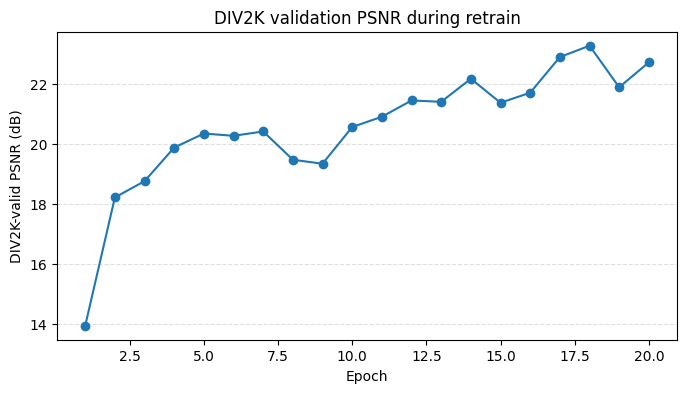

Baseline DIV2K-valid PSNR: 27.23 dB
Final    DIV2K-valid PSNR: 22.74 dB


In [15]:
# Plot DIV2K validation PSNR curve during retrain
import matplotlib.pyplot as plt

if 'div2k_psnr_history' in globals() and len(div2k_psnr_history) > 0:
    epochs = list(range(1, len(div2k_psnr_history) + 1))
    plt.figure(figsize=(8, 4))
    plt.plot(epochs, div2k_psnr_history, marker="o")
    plt.xlabel("Epoch")
    plt.ylabel("DIV2K-valid PSNR (dB)")
    plt.title("DIV2K validation PSNR during retrain")
    plt.grid(axis="y", linestyle="--", alpha=0.4)
    plt.show()

    print(f"Baseline DIV2K-valid PSNR: {baseline_div2k_psnr:.2f} dB")
    print(f"Final    DIV2K-valid PSNR: {final_div2k_psnr:.2f} dB")
else:
    print("No DIV2K PSNR history found. Run the DIV2K retrain cell first.")


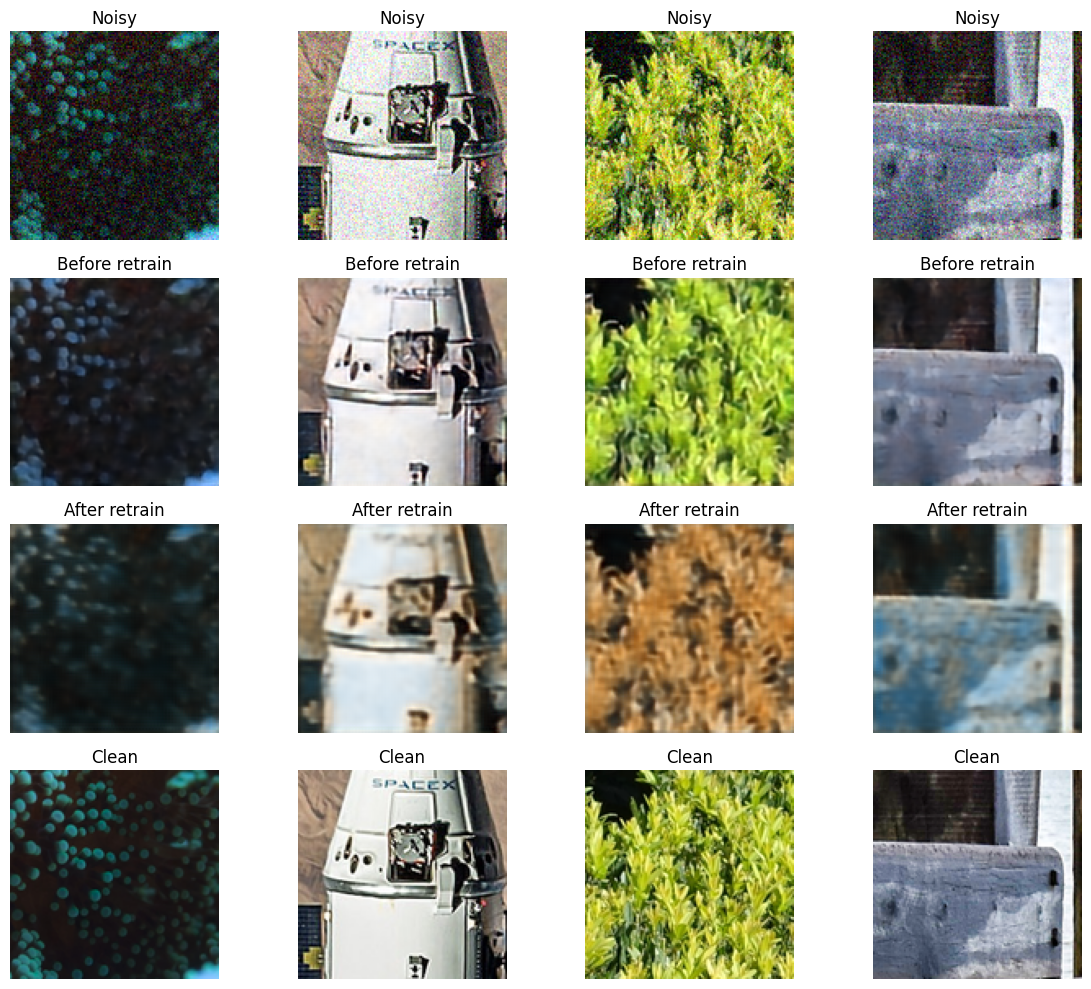

In [18]:
# Helper function to display tensors
def imshow_tensor(img_tensor, title=None):
    # img_tensor: (C, H, W)
    img = img_tensor.numpy().transpose((1, 2, 0))
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    if title:
        plt.title(title)
    plt.axis('off')

# Visual comparison: noisy / denoised (before retrain) / denoised (after retrain) / clean

# Load a separate copy of the model with pre-retraining (STL10-only) weights
model_before = FFDNet(in_nc=3, out_nc=3, nc=64, nb=15, act_mode='R').to(device)
# Ensure the file exists or handle the path correctly.
# Assuming 'ffdnet_stl10_official_style.pth' was saved in the current directory or drive path.
if os.path.exists("ffdnet_stl10_official_style.pth"):
    state_dict_path = "ffdnet_stl10_official_style.pth"
else:
    # Fallback to the path defined earlier if the local file isn't found
    state_dict_path = model_path

if os.path.exists(state_dict_path):
    state_dict_before = torch.load(state_dict_path, map_location=device)
    model_before.load_state_dict(state_dict_before)
else:
    print(f"Warning: Could not find checkpoint at {state_dict_path}. Comparison might use current weights or random weights.")

model_before.eval()
model_after = model  # current fine-tuned model
model_after.eval()

# Get a batch from DIV2K test split loader
# Get a batch from DIV2K test split loader
noisy_batch, clean_batch, sigma_batch = next(iter(hr_test_loader))
noisy_batch = noisy_batch.to(device)
clean_batch = clean_batch.to(device)
sigma_batch = sigma_batch.to(device)

with torch.no_grad():
    denoised_before = model_before(noisy_batch, sigma_batch).clamp(0.0, 1.0)
    denoised_after  = model_after(noisy_batch, sigma_batch).clamp(0.0, 1.0)

N_show = min(5, noisy_batch.size(0))   # ✅ prevents out-of-bounds
plt.figure(figsize=(12, 10))

for i in range(N_show):
    plt.subplot(4, N_show, i + 1)
    imshow_tensor(noisy_batch[i].cpu(), "Noisy")

    plt.subplot(4, N_show, N_show + i + 1)
    imshow_tensor(denoised_before[i].cpu(), "Before retrain")

    plt.subplot(4, N_show, 2 * N_show + i + 1)
    imshow_tensor(denoised_after[i].cpu(), "After retrain")

    plt.subplot(4, N_show, 3 * N_show + i + 1)
    imshow_tensor(clean_batch[i].cpu(), "Clean")

plt.tight_layout()
plt.show()
